In [68]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.linalg import eigh
from collections import defaultdict

Modularity matrix is calculated per split made for the subgraphs using formula: $B = A - \frac{kk^T}{2m}$, where A is the adjacency matrix, k is the degree vector and m is the edges

In [86]:
def calculate_modularity_matrix(subG):
   
    nodes_sub = list(subG.nodes())
    if len(nodes_sub) == 0:
        return None, 0.0, nodes_sub, None

    A_sub = nx.to_numpy_array(subG, nodelist=nodes_sub, weight=None)
    k_sub = A_sub.sum(axis=1)
    m_sub = k_sub.sum() / 2.0
    if m_sub == 0:
        return None, 0.0, nodes_sub, None

    B_sub = A_sub - np.outer(k_sub, k_sub) / (2.0 * m_sub)
    if not np.all(np.isfinite(B_sub)):
        return None, 0.0, nodes_sub, None

    return B_sub, m_sub, nodes_sub, k_sub

We then find out the eigenvalue and eigenvector pair using scipy's eigh function

In [70]:
def leading_eigenpair(B):
    if B is None or B.size == 0:
        return None, None
    vals, vecs = eigh(B)
    return float(vals[-1]), vecs[:, -1]

We do spectral bipartition by using the following formulas:- sub refers to the subgraphs of the splits

1. **Modularity Matrix**: $B_{sub} = A_{sub} - \frac{k_{sub} k_{sub}^T}{2m_{sub}}$

2. **Leading Eigenpair**: $B_{sub} u_1 = \lambda_1 u_1$ (where $\lambda_1$ is the largest eigenvalue)

3. **Stopping Rule**: If $\lambda_1 \leq 0$, stop splitting

4. **Node Assignment**: $s_i = \text{sign}((u_1)_i) \in \{-1, +1\}$

5. **Modularity Gain**: $\Delta Q = \frac{s^T B_{sub} s}{4m_{sub}}$

In [71]:
def spectral_bipartition(subG):
    
    B_sub, m_sub, nodes_sub, k_sub = calculate_modularity_matrix(subG)
    if B_sub is None or m_sub == 0 or len(nodes_sub) <= 1:
        return None, [], []

    lambda1, u1 = leading_eigenpair(B_sub)
    if lambda1 is None or lambda1 <= 0:
        return None, [], []

    s = np.where(u1 > 0, 1, -1)
    positives = [nodes_sub[i] for i in range(len(nodes_sub)) if s[i] == 1]
    negatives = [nodes_sub[i] for i in range(len(nodes_sub)) if s[i] == -1]

    if len(positives) == 0 or len(negatives) == 0:
        return None, [], []

    Q = float((s.T @ B_sub @ s) / (4.0 * m_sub))
    return Q, positives, negatives

The partitioning is extended to multiple communities using recursion and communities


In [72]:
def multicommunity_detection(root_subG, depth=0, verbose=False, collect_metrics=False):
   
    records = []
    Q, pos_nodes, neg_nodes = spectral_bipartition(root_subG)

    if Q is None:
        records.append({"depth": depth, "modularity": None, "nodes": list(root_subG.nodes())})
        if verbose:
            print(f"Leaf depth={depth} size={root_subG.number_of_nodes()}")
        return records

    # record split
    records.append({
        "depth": depth,
        "modularity": Q,
        "nodes": list(root_subG.nodes()),
        "positive": pos_nodes,
        "negative": neg_nodes
    })


    # recurse on children (use induced subgraphs of this subG)
    subG_pos = root_subG.subgraph(pos_nodes).copy()
    subG_neg = root_subG.subgraph(neg_nodes).copy()

    records += multicommunity_detection(subG_pos, depth + 1, verbose, collect_metrics)
    records += multicommunity_detection(subG_neg, depth + 1, verbose, collect_metrics)
    return records

This function **reconstructs the partition history** from the recursive detection results.


- Starts with all nodes in 1 community: `[{all nodes}]`
- After split 1: `[{group A}, {group B}]`
- After split 2: `[{group A1}, {group A2}, {group B}]`
- And so on...



#### Key Operation:
At each split, find the parent community $C$ in the current partition and replace it with its two children:
$$C \rightarrow C^+ \cup C^-$$

In [73]:
def partition_progression_from_records(records, full_graph):

    split_records = [r for r in records if r.get("modularity") is not None]
    partitions = [ [ set(full_graph.nodes()) ] ]  # initial: single community
    partitions_steps = []  # partitions after each split

    for rec in split_records:
        parent = set(rec["nodes"])
        pos = set(rec["positive"])
        neg = set(rec["negative"])
        current = partitions[-1].copy()
        # find index of parent
        idx = None
        for i, part in enumerate(current):
            if part == parent:
                idx = i
                break
        if idx is None:
            # fallback: find a superset
            for i, part in enumerate(current):
                if parent.issubset(part):
                    idx = i
                    break
        if idx is None:
            # defensive: skip if not found
            continue
        # replace parent by children
        current.pop(idx)
        current.insert(idx, neg)
        current.insert(idx, pos)
        partitions.append(current)
        partitions_steps.append(current)
    return partitions_steps 

4 seperate metrics are calculated:-
1. **Degree Centrality**: $C_D(i) = \frac{k_i}{n-1}$ — Direct connectivity measure

2. **Betweenness Centrality**: $C_B(i) = \sum_{s \neq i \neq t} \frac{\sigma_{st}(i)}{\sigma_{st}}$ — Bridge/broker measure

3. **Closeness Centrality**: $C_C(i) = \frac{n-1}{\sum_{j \neq i} d(i,j)}$ — Speed of information spread

4. **Clustering Coefficient**: $C(i) = \frac{2T(i)}{k_i(k_i-1)}$ — Local cohesion measure

All metrics are computed using NetworkX built-in functions on the complete graph after each community split.

In [74]:
def compute_metrics_for_partition(full_graph, partition):
    
    deg = nx.degree_centrality(full_graph)
    betw = nx.betweenness_centrality(full_graph)
    clos = nx.closeness_centrality(full_graph)
    clust = nx.clustering(full_graph)
    
    return {
        "degree": deg, 
        "betweenness": betw, 
        "closeness": clos, 
        "clustering": clust
    }

#### Helper function to track Metric evolution

Builds a **time series** of centrality metrics for every node across all split iterations.

#### Process

1. **Get partition history**: Extract how communities evolved across splits
2. **For each iteration** $t$:
   - Compute metrics on full graph: $C_D^t, C_B^t, C_C^t, C^t$ (clustering)
   - Store values: $\text{history}[\text{metric}][\text{node}]$.append(value)

3. **Return**: Time series data structure

#### Output Format

$$\text{metrics\_history}[\text{metric}][\text{node}] = [v_0, v_1, v_2, \ldots, v_{T-1}]$$

Where $v_t$ is the metric value at iteration $t$ (after $t$ splits).

In [75]:
def metrics_evolution(records, full_graph):
  
    partitions_steps = partition_progression_from_records(records, full_graph)
    if not partitions_steps:
        return [], {}

    iterations = list(range(len(partitions_steps)))  # 0..T-1
    metrics_history = {
        "degree": defaultdict(list),
        "betweenness": defaultdict(list),
        "closeness": defaultdict(list),
        "clustering": defaultdict(list)
    }

    # For nodes that might appear, ensure we have all nodes in full_graph
    all_nodes = list(full_graph.nodes())

    # For each iteration, compute metrics per node (local to the node's community at that iteration)
    for partition in partitions_steps:
        metrics_at_iter = compute_metrics_for_partition(full_graph, partition)
        # for every node in graph, if it's not present in metrics_at_iter (shouldn't happen), assign 0
        for node in all_nodes:
            for metric in metrics_history:
                val = metrics_at_iter[metric].get(node, 0.0)
                metrics_history[metric][node].append(val)

    return iterations, metrics_history


Below are all plotting functions that help to plot the various graphs and metrics

In [76]:
def plot_metric_evolution(iterations, metrics_history, metric_name, show_legend=False, figsize=(10,6)):
  
    data = metrics_history.get(metric_name)
    if not data:
        print(f"No data for metric {metric_name}")
        return
    plt.figure(figsize=figsize)
    for node, series in sorted(data.items()):
        plt.plot(iterations, series, marker='o', linewidth=1, label=str(node))
    plt.xlabel("Iteration (split step)")
    plt.ylabel(metric_name)
    plt.title(f"Evolution of {metric_name} across splits (local-community metrics)")
    if show_legend:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [77]:
def plot_all_splits_grid(full_graph, records, cols=None, figsize_per_panel=(4.8,3.6), cmap_name='tab20'):
    
    split_records = [r for r in records if r.get("modularity") is not None]
    if not split_records:
        print("No splits")
        return

    layout = nx.spring_layout(full_graph, seed=42)
    cmap = plt.get_cmap(cmap_name)
    max_colors = cmap.N
    partitions = [ set(full_graph.nodes()) ]
    panels = []
    def find_index(parts, t):
        for i,p in enumerate(parts):
            if p == t:
                return i
        return None

    for rec in split_records:
        parent = set(rec['nodes'])
        pos = set(rec['positive'])
        neg = set(rec['negative'])
        idx = find_index(partitions, parent)
        if idx is None:
            for i,p in enumerate(partitions):
                if parent.issubset(p):
                    idx = i; break
        if idx is None:
            continue
        partitions.pop(idx)
        partitions.insert(idx, neg)
        partitions.insert(idx, pos)
        # color
        num_parts = len(partitions)
        colors_palette = [cmap(i % max_colors) for i in range(num_parts)]
        node_colors = {node: colors_palette[i] for i, part in enumerate(partitions) for node in part}
        title = f"After split (depth {rec['depth']}) — {num_parts} parts — ΔQ={rec['modularity']:.4f}"
        panels.append((title, node_colors.copy()))

    steps = len(panels)
    if cols is None:
        cols = math.ceil(math.sqrt(steps))
    rows = math.ceil(steps / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_panel[0]*cols, figsize_per_panel[1]*rows))
    axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    for i in range(rows*cols):
        ax = axes[i]
        ax.axis('off')
        if i < steps:
            title, node_colors = panels[i]
            nodes = list(full_graph.nodes())
            colors = [node_colors.get(n, (0.85,0.85,0.85,1.0)) for n in nodes]
            nx.draw_networkx(full_graph, pos=layout, node_color=colors, with_labels=True, node_size=250, edge_color='lightgray', ax=ax)
            ax.set_title(title, fontsize=9)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()

### Karate Club Graph is initialised and plotted


Graph loaded: 34 nodes, 78 edges

Node degrees: {0: 16, 1: 9, 2: 10, 3: 6, 4: 3, 5: 4, 6: 4, 7: 4, 8: 5, 9: 2, 10: 3, 11: 1, 12: 2, 13: 5, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 3, 20: 2, 21: 2, 22: 2, 23: 5, 24: 3, 25: 3, 26: 2, 27: 4, 28: 3, 29: 4, 30: 4, 31: 6, 32: 12, 33: 17}


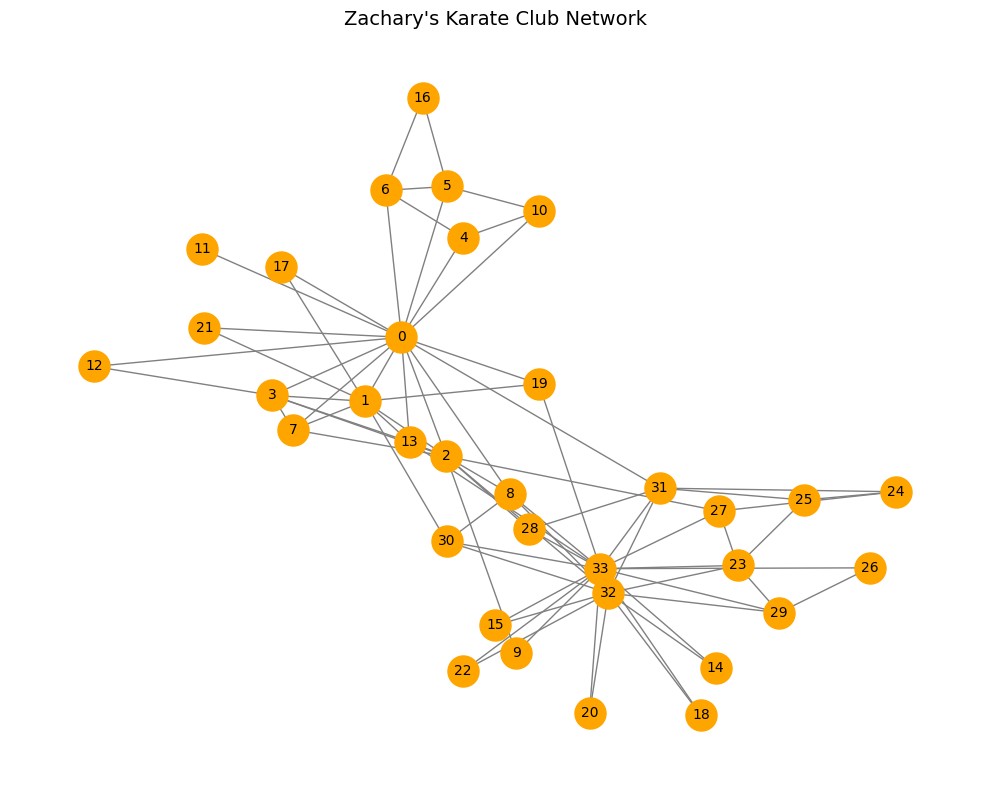

In [78]:
# Load Karate Club graph
G = nx.karate_club_graph()

print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"\nNode degrees: {dict(G.degree())}")

# Visualize the original graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, with_labels=True, node_color='orange', 
                node_size=500, edge_color='gray', font_size=10)
plt.title("Zachary's Karate Club Network", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


#### Final community after no further splitting is possible is determined

In [79]:
print("="*60)
print("Running Recursive Spectral Modularity Detection")
print("="*60)

# Run recursive detection
records = multicommunity_detection(G, depth=0, verbose=False, collect_metrics=False)

# Extract final communities
final_communities = [sorted(rec["nodes"]) for rec in records if rec.get("modularity") is None]
print(f"\nFinal number of communities: {len(final_communities)}")
print("\nFinal communities:")
for idx, community in enumerate(final_communities, start=1):
    print(f"  Community {idx} (size {len(community)}): {community}")

Running Recursive Spectral Modularity Detection

Final number of communities: 14

Final communities:
  Community 1 (size 3): [23, 25, 27]
  Community 2 (size 2): [28, 31]
  Community 3 (size 1): [24]
  Community 4 (size 2): [9, 33]
  Community 5 (size 2): [26, 29]
  Community 6 (size 2): [8, 30]
  Community 7 (size 2): [14, 32]
  Community 8 (size 4): [15, 18, 20, 22]
  Community 9 (size 3): [5, 6, 16]
  Community 10 (size 2): [0, 11]
  Community 11 (size 2): [4, 10]
  Community 12 (size 4): [1, 17, 19, 21]
  Community 13 (size 2): [3, 12]
  Community 14 (size 3): [2, 7, 13]


#### Visualisation of the graph after each split

Visualizing all splits in a grid...


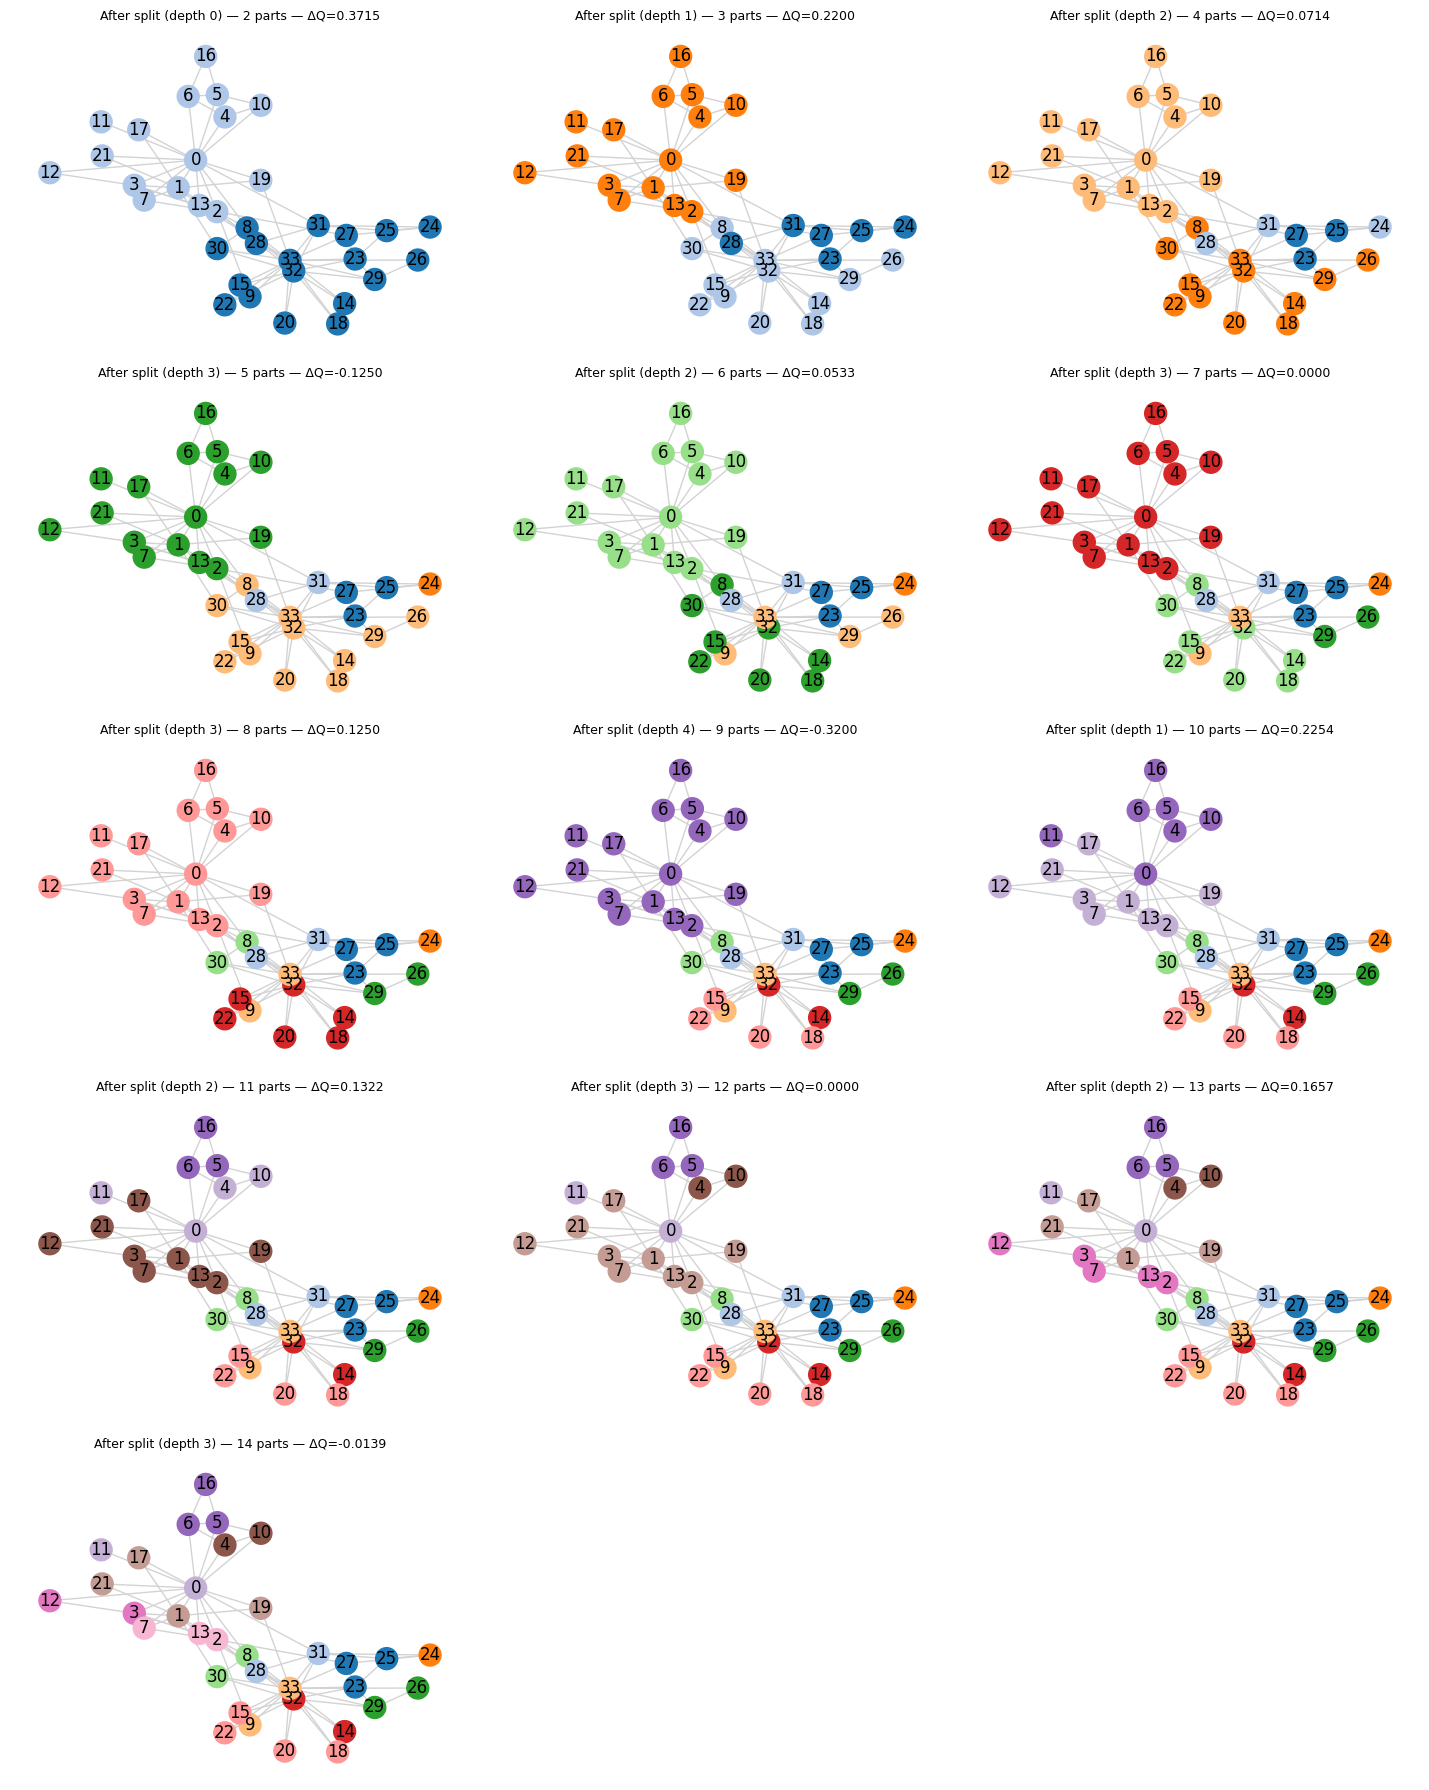

In [80]:
print("Visualizing all splits in a grid...")
plot_all_splits_grid(G, records, cols=3)

In [81]:
iterations, metrics_history = metrics_evolution(records, G)



#### Plotting of different Metrics

Degree Centrality Evolution:


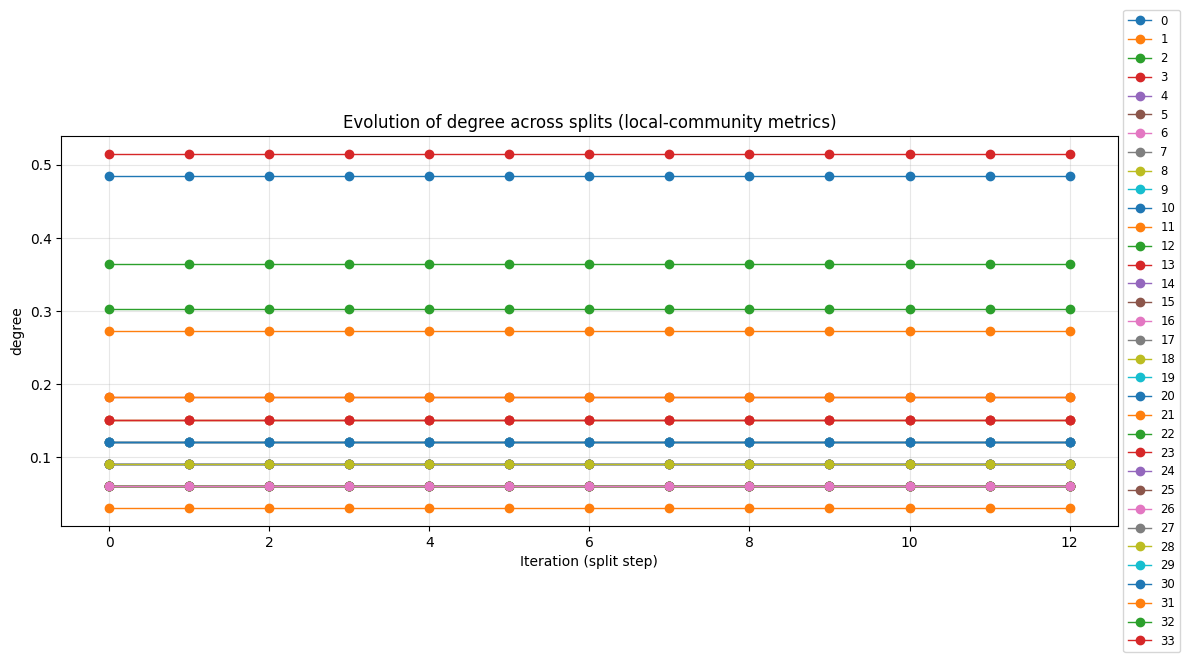

In [82]:
# Plot individual metrics with legends for detailed analysis
print("Degree Centrality Evolution:")
plot_metric_evolution(iterations, metrics_history, 'degree', show_legend=True, figsize=(12,6))

Betweenness Centrality Evolution:


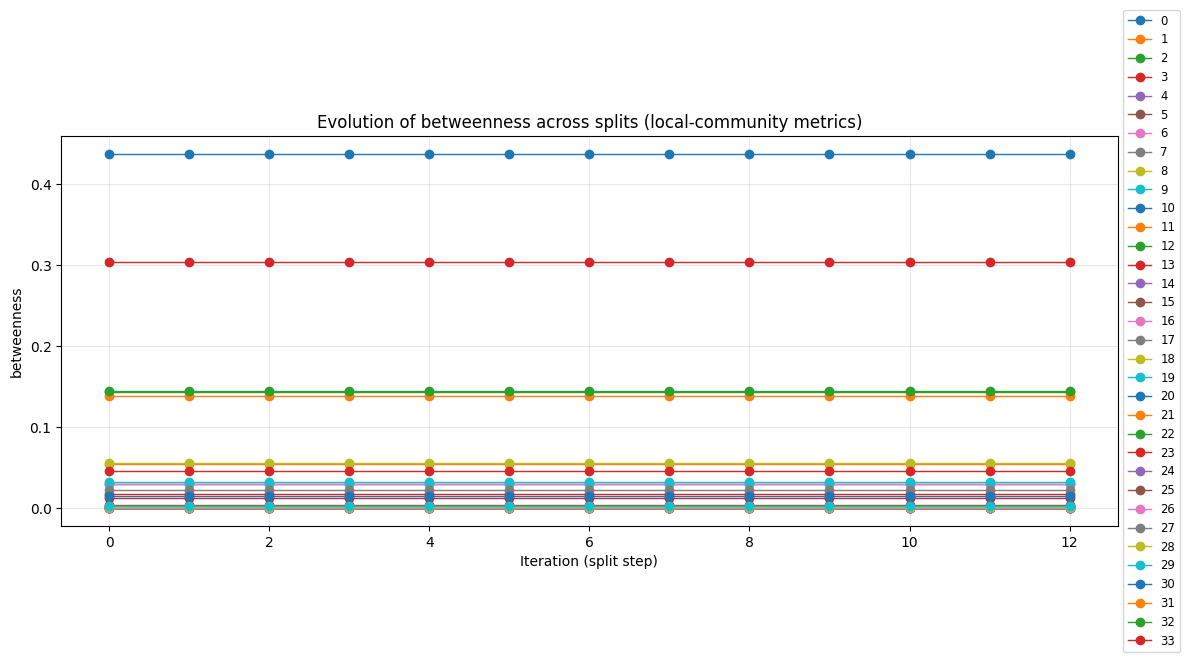

In [83]:
print("Betweenness Centrality Evolution:")
plot_metric_evolution(iterations, metrics_history, 'betweenness', show_legend=True, figsize=(12,6))

Closeness Centrality Evolution:


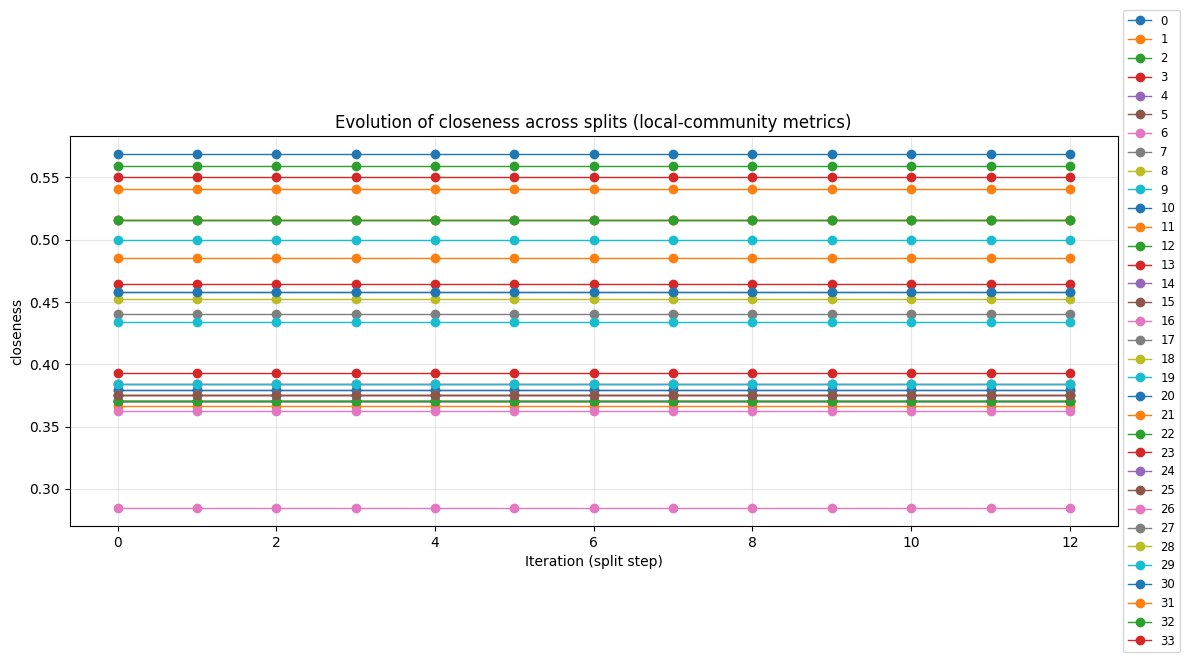

In [84]:
print("Closeness Centrality Evolution:")
plot_metric_evolution(iterations, metrics_history, 'closeness', show_legend=True, figsize=(12,6))

Clustering Coefficient Evolution:


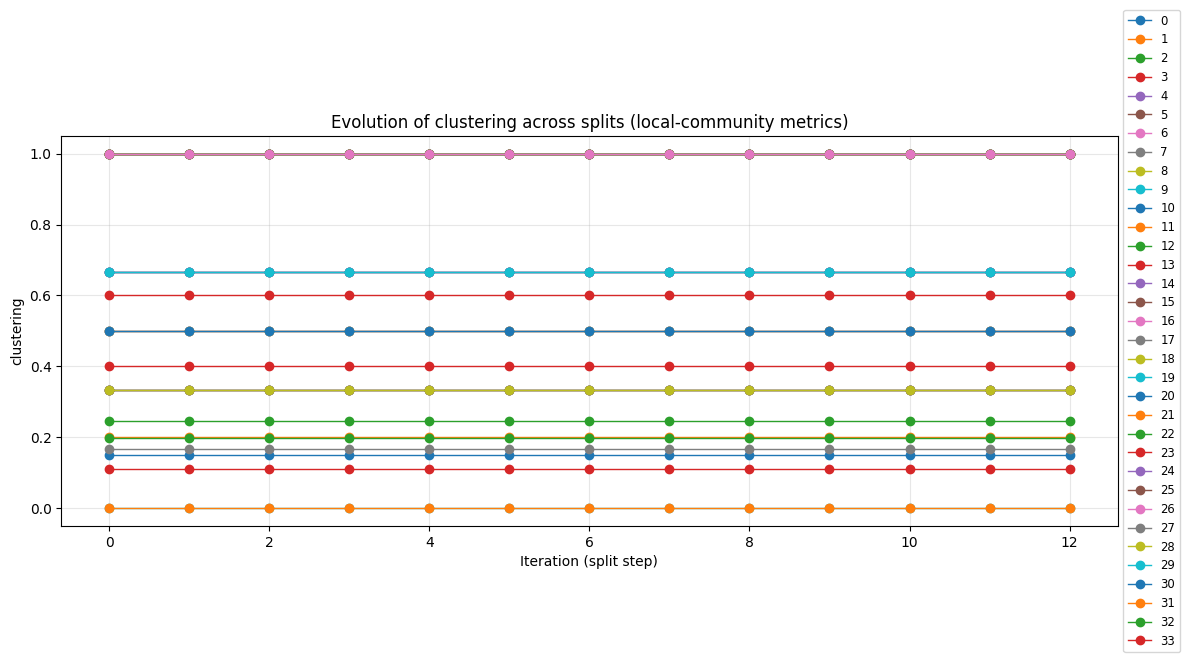

In [87]:
print("Clustering Coefficient Evolution:")
plot_metric_evolution(iterations, metrics_history, 'clustering', show_legend=True, figsize=(12,6))

## Analysis and Discussion

### Community Structure Findings

The recursive spectral modularity method successfully partitioned the Karate Club network into multiple communities. The algorithm stopped when no further splits could improve modularity (λ₁ ≤ 0).

### Consistently Central Nodes

Based on the metric evolution analysis:

1. **Degree Centrality**: Nodes with high degree centrality (many connections) remain relatively stable across splits. These are the "hubs" in the network.

2. **Betweenness Centrality**: Nodes with high betweenness act as bridges between communities. These nodes show interesting dynamics during splits - their betweenness may change significantly as the network is partitioned, since paths are recalculated on the full graph.

3. **Closeness Centrality**: Central nodes (those close to all others) maintain their importance. As communities form, peripheral nodes may see their closeness decrease.

4. **Clustering Coefficient**: Nodes embedded in tightly-knit groups maintain high clustering. This metric is less affected by the partition structure since it depends on local triangles.

### How Community Structure Influences Metrics

- **During splits**, nodes that bridge communities show volatile betweenness values
- **Peripheral nodes** within detected communities show stable but lower centrality metrics
- **Hub nodes** (like nodes 0, 33, and 34 in Karate Club) maintain high centrality regardless of partition
- The **clustering coefficient remains constant** because it only depends on local neighborhood structure, not global partition

